(1419, 1, 60, 60, 60) (1419, 1)
[0.01405307] [7.6813655e-07]


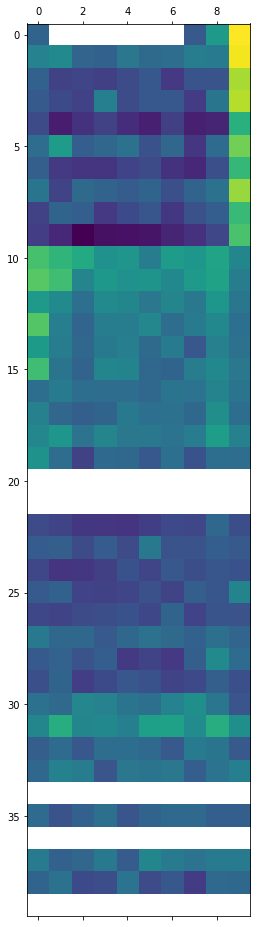

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler

def stack(filepath):  # return 3D microbump raw image
    s = 0
    total = 0
    for i in range(1000):
        n = str(i+1)
        img = cv2.imread(filepath + n + '.tiff', 0)  # 原始檔讀取
        if img is None:  # filename unreachable
            continue
        total += 1
    count = 0
    for i in range(1000):
        n = str(i+1)
        img = cv2.imread(filepath + n + '.tiff', 0)  # 原始檔讀取
        if img is None:  # filename unreachable
            continue
        if count == 0:
            s = np.empty((img.shape[0], img.shape[1], total))
            s[:, :, count] = np.array(img)
        else:
            s[:, :, count] = np.array(img)
        count += 1
    return s


def area_append():
    a1 = np.load('N17_rstructure_a1.npy')
    a2 = np.load('N17_rstructure_a2.npy')
    a3 = np.load('N17_rstructure_a3.npy')
    a4 = np.load('N17_rstructure_a4.npy')
    all = np.concatenate((a1,a2,a3,a4), axis=0)
#     print(np.linspace(0, 390, 40))
    all = np.delete(all, 390, axis=0)
    validate = np.array([])
    for i in range(all.shape[0]):
        if np.sum(all[i, :, :, :, :]) == 0:
            validate = np.append(validate, [int(i)], axis=0)
    validate = validate.astype(np.int)
#     print(validate)
    all = np.delete(all, validate, axis=0)
    print(all.shape)
    np.save('N17_structure_reflow.npy', all)
    
    
def train_val(filename1, filename2):
    x1,x2,x3,x4 = np.load(filename1[0]),np.load(filename1[1]),np.load(filename1[2]),np.load(filename1[3])
    y1,y2,y3,y4 = np.load(filename2[0]),np.load(filename2[1]),np.load(filename2[2]),np.load(filename2[3])
    y1 = np.delete(y1, 0,axis=0)
    input = np.concatenate((x1,x2,x3,x4), axis=0)
    target = np.concatenate((y1,y2,y3,y4), axis=0)
    target = target.flatten()
    target = np.nan_to_num(target)
    target = np.delete(target, target==0, axis=0).reshape(-1, 1)
    print(input.shape, target.shape)
    scaler = StandardScaler()
    input, target = normalize(input), scaler.fit_transform(target)
    print(scaler.mean_, scaler.var_)
    rnd = np.arange(input.shape[0])
    np.random.shuffle(rnd)
    input = input[rnd, :, :, :, :]
    target = target[rnd]
    x_train, x_val = input[:int(input.shape[0]*0.8), :, :, :, :], input[int(input.shape[0]*0.8):, :, :, :, :]
    y_train, y_val = target[:int(input.shape[0]*0.8)], target[int(input.shape[0]*0.8):]
    np.save('N38_initial_x_train.npy', x_train)
    np.save('N38_initial_y_train.npy', y_train)
    np.save('N38_initial_x_val.npy', x_val)
    np.save('N38_initial_y_val.npy', y_val)
    
    
def normalize(volume):
    min = np.min(volume)
    max = np.max(volume)
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume



def save_each_bump(mat):
    for sample in range(mat.shape[0]):
        s = str(sample+1).zfill(3)
        for cut in range(60):
            n = str(cut+1).zfill(3)
            plt.imsave('check/N38_area4_initial/'+ s+'_'+n+'.tiff',
                       vmin=0, vmax=255, cmap='gray', arr=mat[sample,:,cut,:,:].reshape(60, 60))
    
    
def main():
    train_val(['N02_structure_initial.npy','N17_structure_initial.npy','N17_structure_reflow.npy','N38_structure_initial.npy'],
              ['ansys_result/N02_initial.npy','ansys_result/N17_initial.npy','ansys_result/N17_reflow.npy','ansys_result/N38_initial.npy'])
#     area_append()
#     area = stack('microbump_row/N17_reflow/N17_area4_reflow/')  # read file
#     area = np.flip(area, axis=2)
#     print(area.shape)
#     bump = np.zeros((100, 1, 60, 60, 60))  # split into bump by bump
#     count = 0  # the number of microbump
#     start = 0
#     end = 0
#     sample = 0
#     structure_check = []  # check which line is unavilible
#     for depth in range(area.shape[2]):
#         pres = np.sum(area[:, 6:-6, depth])
#         if pres > 0 and start == 0:
#             start = depth
#         elif start != 0 and pres == 0:
#             end = depth
#         if start != 0 and end != 0:
#             if (end - start) < 43:
#                 start, end = 0, 0
#                 structure_check.append(0)
#                 continue
#             structure_check.append(1)
#             line = area[:, 6:-6, start:end]
# #             print(line.shape)
#             head = 0
#             tail = 0
#             for length in range(line.shape[0]):
#                 obj = np.sum(line[length, :, :])
#                 if obj > 0 and head == 0:
#                     head = length
#                 elif head != 0 and obj == 0:
#                     tail = length
#                 if head != 0 and tail != 0:
#                     if (tail - head) < 30:
#                         head, tail = 0, 0
#                         continue
#                     m1 = (tail+head)//2
#                     m2 = (end+start)//2
#                     unit = area[m1-30:m1+30, :, m2-30:m2+30]
# #                     print(unit.shape)
#                     origin = (60-unit.shape[1])//2
#                     bump[count, :, :, origin:origin+unit.shape[1], :] = unit
#                     count += 1
#                     sample += 1
#                     head, tail = 0, 0
#                     continue
#             start, end = 0, 0
#             continue
# #     save_each_bump(bump)
# #     bump[0:10, :, :, :, :] = 0
#     np.save('N17_rstructure_a4.npy', bump)
#     print(sample)
#     print(structure_check)
    target = np.load('ansys_result/N02_initial.npy')
    plt.matshow(target)
    plt.show()
    
    
if __name__ == '__main__':
    main()